In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import matplotlib.patches
plt.rcParams['figure.figsize'] = 16, 6

# Morphology And Blob Analysis

## Morphology

### Erosion and Dilation

Erosion - removes noise (min operator). Dilation - removes holes and joins nearby blobs (max operator). 
This is a simple and usefull tool for many purposes.

First some salt and pepper noise will be added to make things more interesting

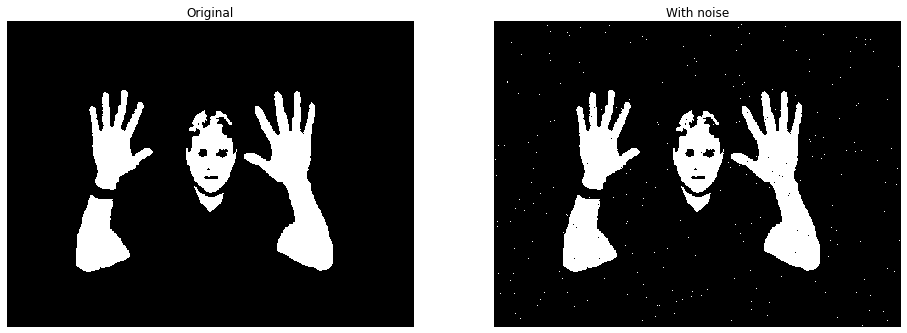

In [2]:
#Read image and add noise
img = cv2.imread(r'skin_map.jpg', 0)
img[img >= 128] = 255
img[img < 128] = 0

#Morphology
def add_salt_and_pepper(image, prob=0.04):
    s_n_p = np.random.rand(image.shape[0], image.shape[1])
    p = s_n_p > 1 - 0.5*prob
    s = s_n_p < 0.5*prob

    noisy = image
    noisy[np.nonzero(p)] = 0
    noisy[np.nonzero(s)] = 255

    return noisy

img_noisy = add_salt_and_pepper(np.copy(img), prob=0.004)
plt.subplot(121), plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_noisy, cmap='gray', interpolation='nearest')
plt.title('With noise'), plt.xticks([]), plt.yticks([]);

Now lets create the kernel using **cv2.getStructuringElement**:

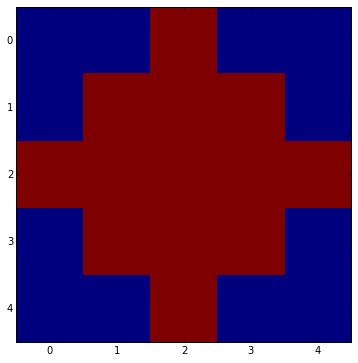

In [3]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel = kernel & np.transpose(kernel)
plt.imshow(kernel,interpolation='nearest');

Experiment with erode and dilate

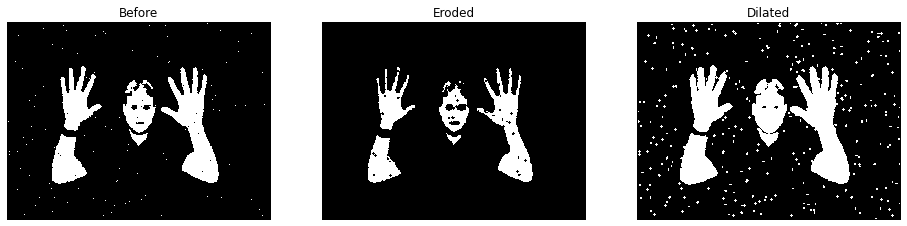

In [4]:
img_eroded = cv2.erode(img_noisy, kernel)
img_dilated = cv2.dilate(img_noisy, kernel)

plt.subplot(131), plt.imshow(img_noisy, cmap='gray', interpolation='nearest')
plt.title('Before'), plt.xticks([]), plt.yticks([]);
plt.subplot(132), plt.imshow(img_eroded, cmap='gray', interpolation='nearest')
plt.title('Eroded'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_dilated, cmap='gray', interpolation='nearest')
plt.title('Dilated'), plt.xticks([]), plt.yticks([]);

How can we use these methods to get the outline of blobs?

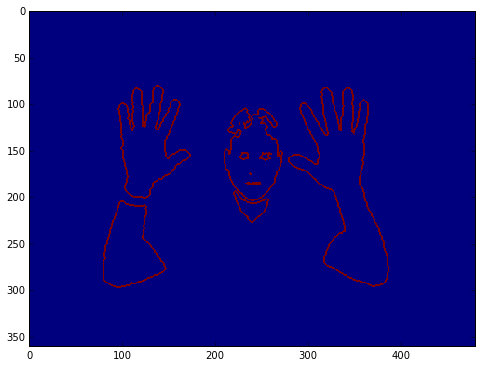

In [5]:
cont = cv2.bitwise_xor(img, cv2.dilate(img, kernel))
plt.imshow(cont, interpolation='nearest');

A small remainder xor = $(\bar{x}\land y)\lor(\bar{y}\land x)$. Or in simple words True if different False if the same.

### Opening and Closing

As we saw above the operators of erosion and dilation are sometime not enough to help extract the information we want and remove the information we don't.

Dilation fills holes but amplifies the noise. Erosion removes the noise but erodes the blobs we are interested in. In this section we will see solutions to these problems.

Erosion also might sever parts of blob from it. Dilation might also join different blobs and obvioulsy this is bad thing. We may not have good solution for this besides for better preprocessing.

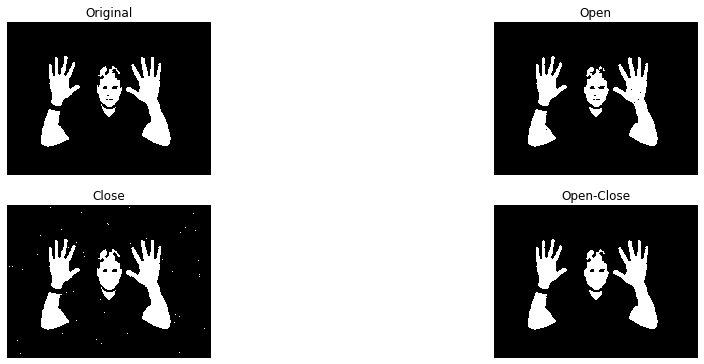

In [6]:
#open - denoise (first erode then dilate)
img_open = cv2.dilate(img_eroded, kernel)

#close - hole filler (dilate then erode)
img_close = cv2.erode(img_dilated, kernel)

#open then close
img_open_close = cv2.dilate(img_open, kernel)
img_open_close = cv2.erode(img_open_close, kernel)

plt.figure(3)
plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(img_open, cmap='gray', interpolation='nearest')
plt.title('Open'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(img_close, cmap='gray', interpolation='nearest')
plt.title('Close'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(img_open_close, cmap='gray', interpolation='nearest')
plt.title('Open-Close'), plt.xticks([]), plt.yticks([])
plt.show()

Opening is the morphological equivalent of filtering noise with a low pass filter. Closing acts as filler for small holes. Both together can make blobs much easier to work with.

##     Blob Analysis          

### Finding blobs

To isolate individual blobs we need to group neighboring pixels together. One way to accomplish this is to use **cv2.findContours**:

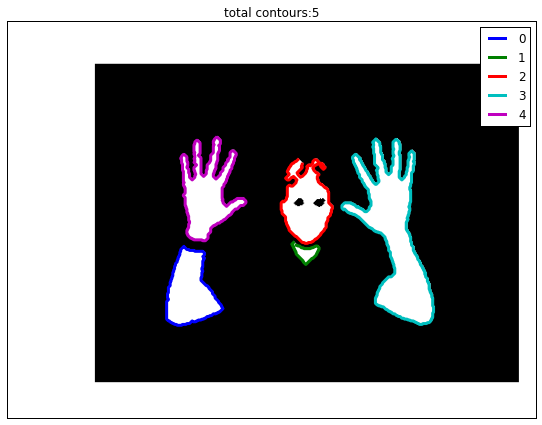

In [7]:
contours, hierarchy = cv2.findContours(np.copy(img_open_close), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(img_open_close, cmap='gray')
for ind,contour in enumerate(contours):
    plt.plot(contour[:,0,0], contour[:,0,1], linewidth=3, label=ind)
plt.xticks([]), plt.yticks([]); 
plt.title('total contours:%d'%len(contours))
plt.legend()
plt.tight_layout()

### Filling Blobs
The main use of the contours here is to mark and label the seperate blobs [Suzuki85](#Bibliography). You can draw contours using **cv2.drawContours**. Finding the contour then filling in blobs is a very slow way to it. However the contours are also useful in finding the moments as we will soon see.

Older versions of opencv don't support [connected component labeling](https://en.wikipedia.org/wiki/Connected-component_labeling#One_component_at_a_time) so this is the main reason for doing it this way here. A better way to do this would be to use 1-pass(depth search) or 2-pass algortihm with union-find data structure.

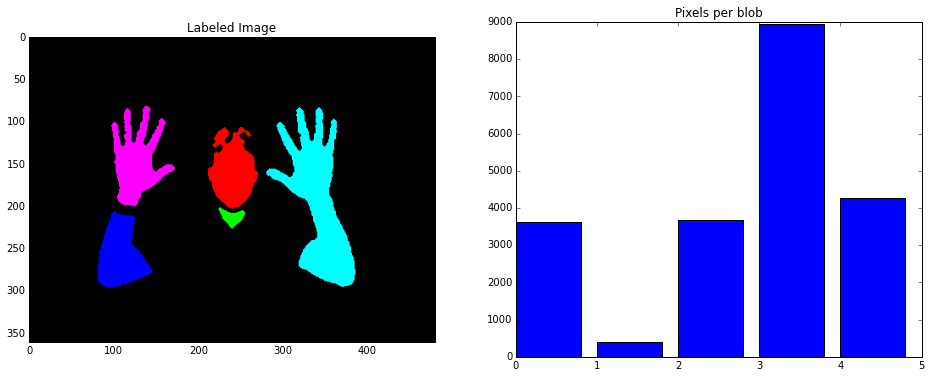

In [8]:
labeled_img = np.zeros(img_open_close.shape + (3, ), np.uint8)
colors = ((0,0,255),(0,255,0),(255,0,0),(0,255,255),(255,0,255))
pnts_list = []
mask_list = []
for ind, contour in enumerate(contours):
    mask = np.zeros(img_open_close.shape, np.uint8)
    cv2.drawContours(mask, [contour], 0, 255, -1, 8)
    pixel_points = cv2.findNonZero(mask)#(x,y)

    labeled_img[mask == 255] = colors[ind]
    pnts_list.append(pixel_points)
    mask_list.append(mask)

plt.subplot(121); plt.imshow(labeled_img); plt.title('Labeled Image')
plt.subplot(122); plt.bar(range(len(pnts_list)), [len(pnts) for pnts in pnts_list]); plt.title('Pixels per blob');

### Moments

Once the connected components are calculated the orientation and center of the blobs can be calculated. There are raw moments and central moments.

#### Raw Moments


$$M_{ij}=\sum_x\sum_yx^iy^jI(x,y)$$

* Area - $M_{00}$
* Centroid - $(\bar{x},\bar{y})=(M_{10}/M_{00}, M_{01}/M_{00})$

With OpenCV you can calculate the moments using **cv2.moments** using only the *contour* (not the blob):

Area is 8578


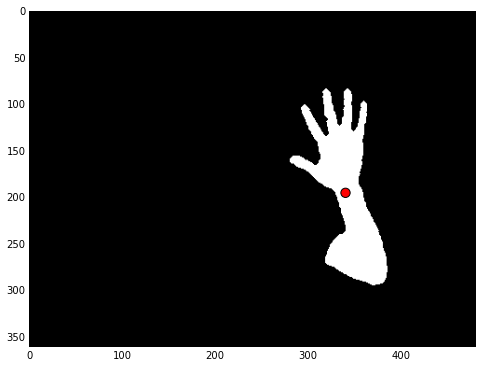

In [9]:
M = cv2.moments(contours[3]) #expects to get a contour - uses Green's theorem
print 'Area is %d' % M['m00']
#center of blob
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

plt.imshow(mask_list[3],cmap='gray')
plt.gca().add_artist(plt.Circle((cx,cy),5,fc='r'));

#### Central Moments 

$$\mu_{pq}=\sum_x\sum_y(\bar{x}-x)^p(\bar{y}-y)^qI(x,y)$$

The only different between the raw and central moments is that the central moments use the Centroid as the point of reference.

For calculating orientation we need the central moments. The normalized central moments are also useful in computer vision:


$$\nu_{ij}=\frac{\mu_{ij}}{\mu_{00}^{1+\frac{i+j}{2}}}$$

The orientation is given by:

$$\theta=\frac{1}{2}\arctan {\frac{2\nu_{11}}{\nu_{20} - \nu_{02}}}$$

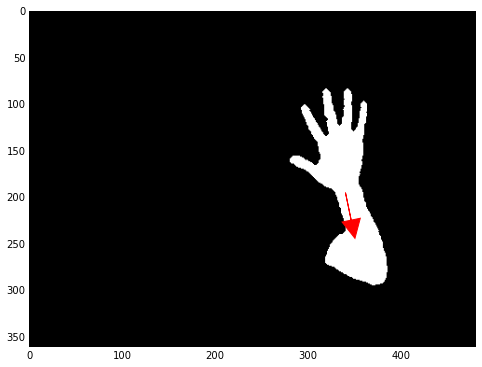

In [10]:
#central moments
nu20_tag = M['nu20']/M['m00']
nu02_tag = M['nu02']/M['m00']
nu11_tag = M['nu11']/M['m00']
theta = 0.5*math.atan2(2*nu11_tag, nu20_tag - nu02_tag)

plt.imshow(mask_list[3],cmap='gray')
plt.gca().arrow(cx,cy,30*np.cos(theta), 30*np.sin(theta),color='red', fc='r', head_width=20, head_length=20);

#### Green's Theorem


The area and other moments can calculated from the contour using [Greens Theorem](https://en.wikipedia.org/wiki/Green%27s_theorem#Area_calculation) [[Yang94]](#Bibliography)

Green's Theorem

$$\oint_C \left(Ldx+Mdy\right)= \iint_D\left(\frac{\partial M}{\partial x} - \frac{\partial L}{\partial y}\right)\,dx\,dy$$


The area of $D$ is given by $A=\iint_A \,dA$. We can choose $L$ and $M$ such that $\frac{\partial M}{\partial x} - \frac{\partial L}{\partial y}=1$.

The indirect calculation of the area is now: $A=\oint_C \left(x\,dy\right)=-\oint_C \left(y\,dx\right)=\frac{1}{2}\oint_C \left(-y\,dx+x\,dy\right)$






### Line fitting

The most basic way to fit a line is to use least squares using $L_2$ as the minimization criterion. 

A better way to do that is using total least sqares. This how line fitting is implemeted in opencv when using $L_2$. For better resilience to outliers one should use $L_1$. This is non-linear and is solved iteratively.

If either method is not good enough one will have to use heavier tools such as RANSAC or Hough transform. 

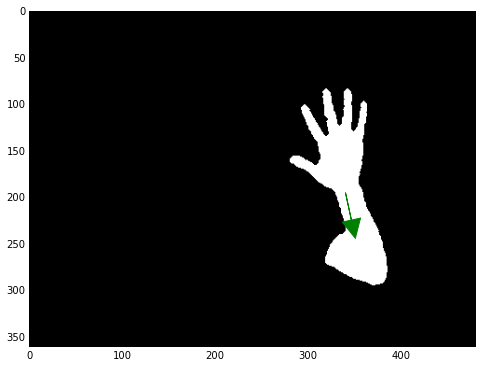

In [11]:
pixel_points = pnts_list[3]

#DIST_L1 = 1: |x1-x2| + |y1-y2|, DIST_L2 = 2: euclidean distance, DIST_C = : max(|x1-x2|,|y1-y2|)
[vx, vy, x, y] = cv2.fitLine(pixel_points, distType=cv2.cv.CV_DIST_L1, param=0, reps=0.01, aeps=0.01)

plt.imshow(mask_list[3],cmap='gray')
plt.gca().arrow(cx,cy,30*float(vx),30*float(vy),color='green', fc='green', head_width=20, head_length=20);

### Fit Ellipse

Yet another approach is to try fit a primitive shape like an ellipse. This requires solving a convex optimization problem. Fortunetly this is already implemented in opencv using **cv2.fitEllipse**:

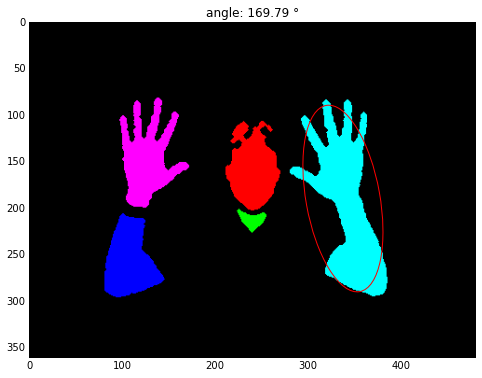

In [12]:
cnt = contours[3]

(x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
plt.imshow(labeled_img)
plt.gca().add_artist(matplotlib.patches.Ellipse([x,y],MA,ma,angle,fill=False, color='r'));
plt.title(u"angle: %.02f \N{DEGREE SIGN}"% angle);

### Summary
Finally lets combine everything together on all blobs. Note that here we use OpenCV's drawing functions to visualize the orientations.

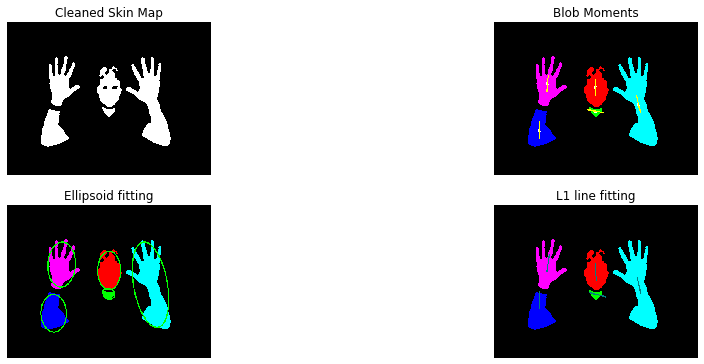

In [13]:
labeled_img1 = np.copy(labeled_img)
labeled_img2 = np.copy(labeled_img)
labeled_img3 = np.copy(labeled_img)

k = 0
for cnt in contours:

    pixel_points = pnts_list[k]

    M = cv2.moments(cnt)#expects to get a contour - uses Green's theorem

    #center of blob
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    #orientation of blob from moments
    #central moments
    nu20_tag = M['nu20']/M['m00']
    nu02_tag = M['nu02']/M['m00']
    nu11_tag = M['nu11']/M['m00']
    theta = 0.5*math.atan2(2*nu11_tag, nu20_tag - nu02_tag)

    pt1 = np.array((cx, cy)) + 20*np.array((np.cos(theta), np.sin(theta)))
    pt2 = np.array((cx, cy)) - 20*np.array((np.cos(theta), np.sin(theta)))

    cv2.rectangle(labeled_img1, (cx-3, cy-3), (cx+3, cy+3), (255, 255, 255), 1, 8)
    cv2.line(labeled_img1, tuple(pt1.astype('int32')), tuple(pt2.astype('int32')), (255, 255, 0), thickness=2,
             lineType=8)

    #ellipsoid outline of blob
    ellipse = cv2.fitEllipse(cnt)
    im = cv2.ellipse(labeled_img2, ellipse, (0, 255, 0), 2)

    (x, y), (MA, ma), angle = cv2.fitEllipse(pixel_points)#yet another way to get the angle


    #line fitting
    #DIST_L1 = 1: |x1-x2| + |y1-y2| */, DIST_L2 = 2: euclidean distance, DIST_C = : max(|x1-x2|,|y1-y2|)

    [vx, vy, x, y] = cv2.fitLine(pixel_points, 1, 0, 0.01, 0.01)
    pt1 = (np.array((x, y)) + 20*np.array((vx, vy))).astype('int32')
    pt2 = (np.array((x, y)) - 20*np.array((vx, vy))).astype('int32')

    cv2.line(labeled_img3, tuple(pt1), tuple(pt2), (0, 128, 128), 2, 8)
    k += 1


plt.figure(4)
plt.subplot(2, 2, 1), plt.imshow(img_open_close, cmap='gray', interpolation='nearest')
plt.title('Cleaned Skin Map'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(labeled_img1, interpolation='nearest')
plt.title('Blob Moments'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(labeled_img2, interpolation='nearest')
plt.title('Ellipsoid fitting'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(labeled_img3, interpolation='nearest')
plt.title('L1 line fitting'), plt.xticks([]), plt.yticks([])
plt.show()

### Notes
Note that numpy arrays are passed by reference. 

$a=b$ 

means a is reference to b not a copy of b. To make a copy use 

$a = np.copy(b)$ 

This fine point can be the cause of very strange bugs.

## Bibliography


[Suzuki85](https://www.google.co.il/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjNi7uv37XKAhWFPhQKHUQ3DHMQFggaMAA&url=https%3A%2F%2Ftpf-robotica.googlecode.com%2Fsvn-history%2Fr397%2Ftrunk%2FVision%2Fpapers%2FSA-CVGIP.PDF&usg=AFQjCNGdyj767sRXdL3v89fgkTL8Ouk9XQ&bvm=bv.112064104,d.ZWU)	Suzuki, S. and Abe, K., Topological Structural Analysis of Digitized Binary Images by Border Following 

[Fitzgibbon95](https://www.google.co.il/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwi4z4XN9LXKAhULvhQKHUn_A6IQFggaMAA&url=http%3A%2F%2Fcseweb.ucsd.edu%2F~mdailey%2FFace-Coord%2Fellipse-specific-fitting.pdf&usg=AFQjCNFm1pNnEntXOvonhOE6ZEfG0R0zzQ&bvm=bv.112064104,d.ZWU) Andrew W. Fitzgibbon, R.B.Fisher. A Buyer’s Guide to Conic Fitting

[Yang94](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.62.9329&rep=rep1&type=pdf) Yang, Luren, and Fritz Albregtsen, Fast and exact computation of moments using discrete Green's theorem